# ResNet50 TransferLearning

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [2]:
# Dwie klasy lepsze od 1!
NUM_CLASSES = 2

# 3 kanały koloru
CHANNELS = 3

# Wielkość ResNetu
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 25
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 50
BATCH_SIZE_VALIDATION = 50

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [3]:
from keras.applications.resnet import ResNet50
from keras.layers import Dense
from keras.models import Sequential
import keras

Using TensorFlow backend.


In [4]:
# Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = True, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [6]:
from keras import optimizers

opt = optimizers.Adam()
model.compile(optimizer = opt, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [7]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

path = '../../MGU/Projekt/PS-Battles-master/' if os.name != 'nt' else '..\..\MGU\Data\PS-Battles-master'
slash = '/' if os.name != 'nt' else '\\'

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        directory=path + slash + 'test' + slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        directory=path + slash + 'valid'+ slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(50, 400, 50, 100)

In [9]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [10]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.hdf5")

Epoch 1/25
10/10 [==============================] - 111s 11s/step - loss: 0.6929 - accuracy: 0.5160 - val_loss: 0.6972 - val_accuracy: 0.5020
Epoch 2/25
10/10 [==============================] - 107s 11s/step - loss: 0.6923 - accuracy: 0.5120 - val_loss: 0.6903 - val_accuracy: 0.5120
Epoch 3/25
10/10 [==============================] - 107s 11s/step - loss: 0.6911 - accuracy: 0.5540 - val_loss: 0.6884 - val_accuracy: 0.5380
Epoch 4/25
10/10 [==============================] - 107s 11s/step - loss: 0.6878 - accuracy: 0.5440 - val_loss: 0.7010 - val_accuracy: 0.5880
Epoch 5/25
10/10 [==============================] - 107s 11s/step - loss: 0.6740 - accuracy: 0.6000 - val_loss: 0.7068 - val_accuracy: 0.5840
Epoch 6/25
10/10 [==============================] - 106s 11s/step - loss: 0.6897 - accuracy: 0.5700 - val_loss: 0.6090 - val_accuracy: 0.5720
Epoch 7/25
10/10 [==============================] - 106s 11s/step - loss: 0.6703 - accuracy: 0.6180 - val_loss: 0.6136 - val_accuracy: 0.6260
Epoch 

d:\programs\python37\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 106s 11s/step - loss: 0.6653 - accuracy: 0.6020 - val_loss: 0.6551 - val_accuracy: 0.6120


In [11]:
print(fit_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


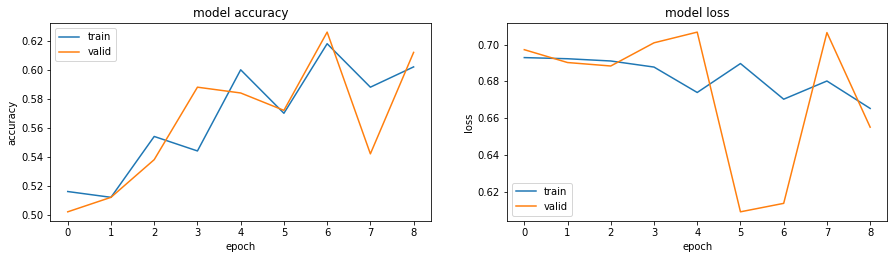

In [12]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [13]:
test_generator = data_generator.flow_from_directory(
    directory = path + slash + 'show' + slash,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 29 images belonging to 1 classes.


In [14]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

29/29 [==============================] - 4s 137ms/step


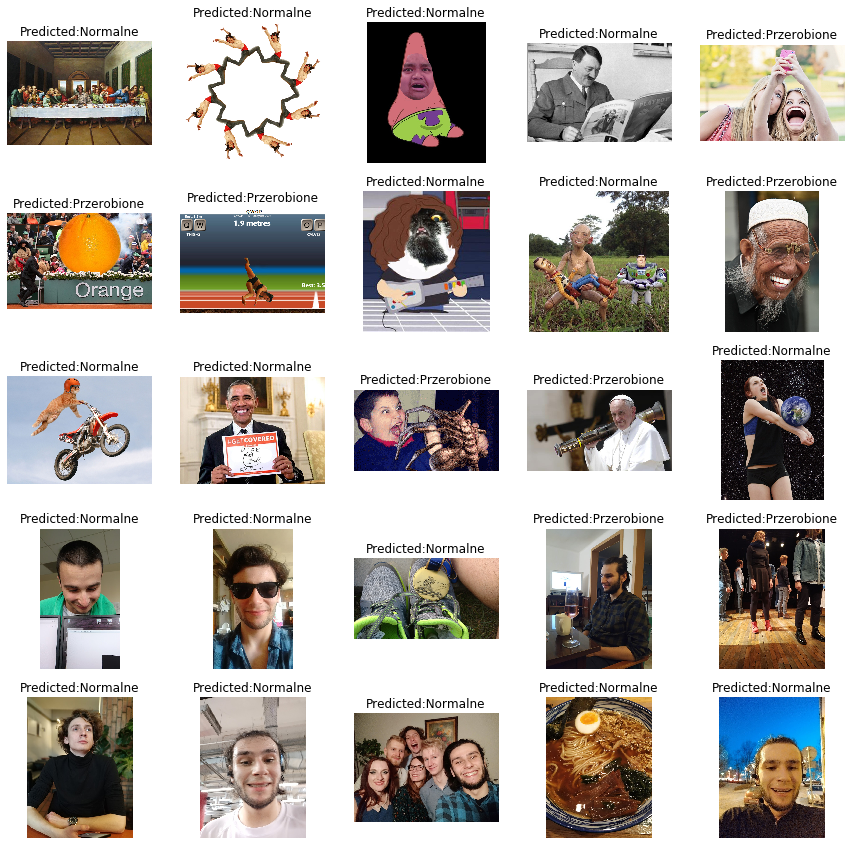

In [15]:
TEST_DIR = path + slash + 'show' + slash
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Normalne" if predicted_class_indices[i] else "Przerobione"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()